# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from IPython.display import display
import datetime
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle
#from sklearn.compose import ColumnTransformer, make_column_transformer
#import cufflinks as cf
#cf.go_offline()

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep= ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
#with open('Data_Dictionary.md', 'r') as f:
    #get_ipython().set_next_input(f.read())

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
print(feat_info.shape)
#azdias.describe()
azdias.head()
display(feat_info.head(100))

(891221, 85)
(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
azdias.shape

(891221, 85)

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
def repalce_missing_with_NAN(feat_info,df_data):
    missing_vals_dict = pd.Series(feat_info.missing_or_unknown.values,index=feat_info.attribute.values).to_dict()
    counter = 0
    print_status = 10
    for key,val in missing_vals_dict.items():
                   
        #print(f"The key and val is {key} {val}")
        if len(val[1:-1]) > 0:
            miss_list = [x.strip() for x in val[1:-1].split(',')]
            miss_list_num = [ int(x) if x.lstrip("-").isdigit() else x for x in miss_list ]
            df_data[key] = df_data[key].replace(miss_list_num,np.nan)
            
        else:
            #print("Skipping")
            pass
        counter += 1
    return df_data


In [7]:
azdias = repalce_missing_with_NAN(feat_info,azdias)


In [8]:
#azdias.info()
azdias.isnull().sum().sort_values(ascending=False)[:20]

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
REGIOTYP          158064
KKK               158064
W_KEIT_KIND_HH    147988
KBA05_ANTG4       133324
KBA05_GBZ         133324
MOBI_REGIO        133324
KBA05_ANTG1       133324
KBA05_ANTG2       133324
KBA05_ANTG3       133324
PLZ8_GBZ          116515
PLZ8_HHZ          116515
PLZ8_BAUMAX       116515
PLZ8_ANTG4        116515
PLZ8_ANTG1        116515
dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

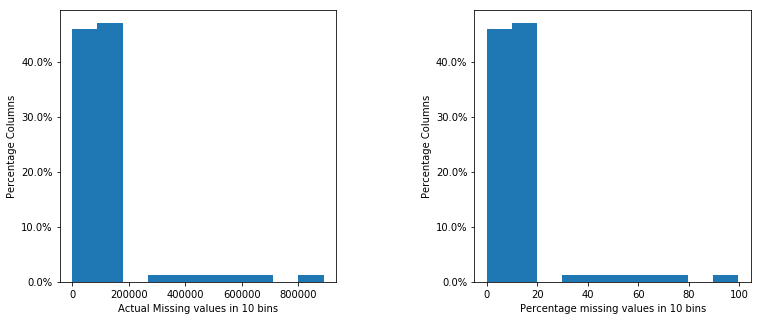

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

data= azdias.isnull().sum()[:]
bins = 10
fig,axes = plt.subplots(1,2,figsize=(24,5))

axes[0].hist(data,weights = np.ones(len(data)) / len(data), bins=10)
axes[0].yaxis.set_major_formatter(PercentFormatter(1))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.gca.
axes[0].set_ylabel('Percentage Columns')
axes[0].set_xlabel('Actual Missing values in '+str(bins)+ " bins")



percent_data = (azdias.isnull().sum()/azdias.shape[0])*100
axes[1].hist(percent_data,weights = np.ones(len(data)) / len(data), bins=10)
axes[1].yaxis.set_major_formatter(PercentFormatter(1))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
axes[1].set_ylabel('Percentage Columns')
axes[1].set_xlabel('Percentage missing values in '+str(bins)+ " bins")

plt.subplots_adjust(left  = 0.5,wspace = 0.5)

plt.show()



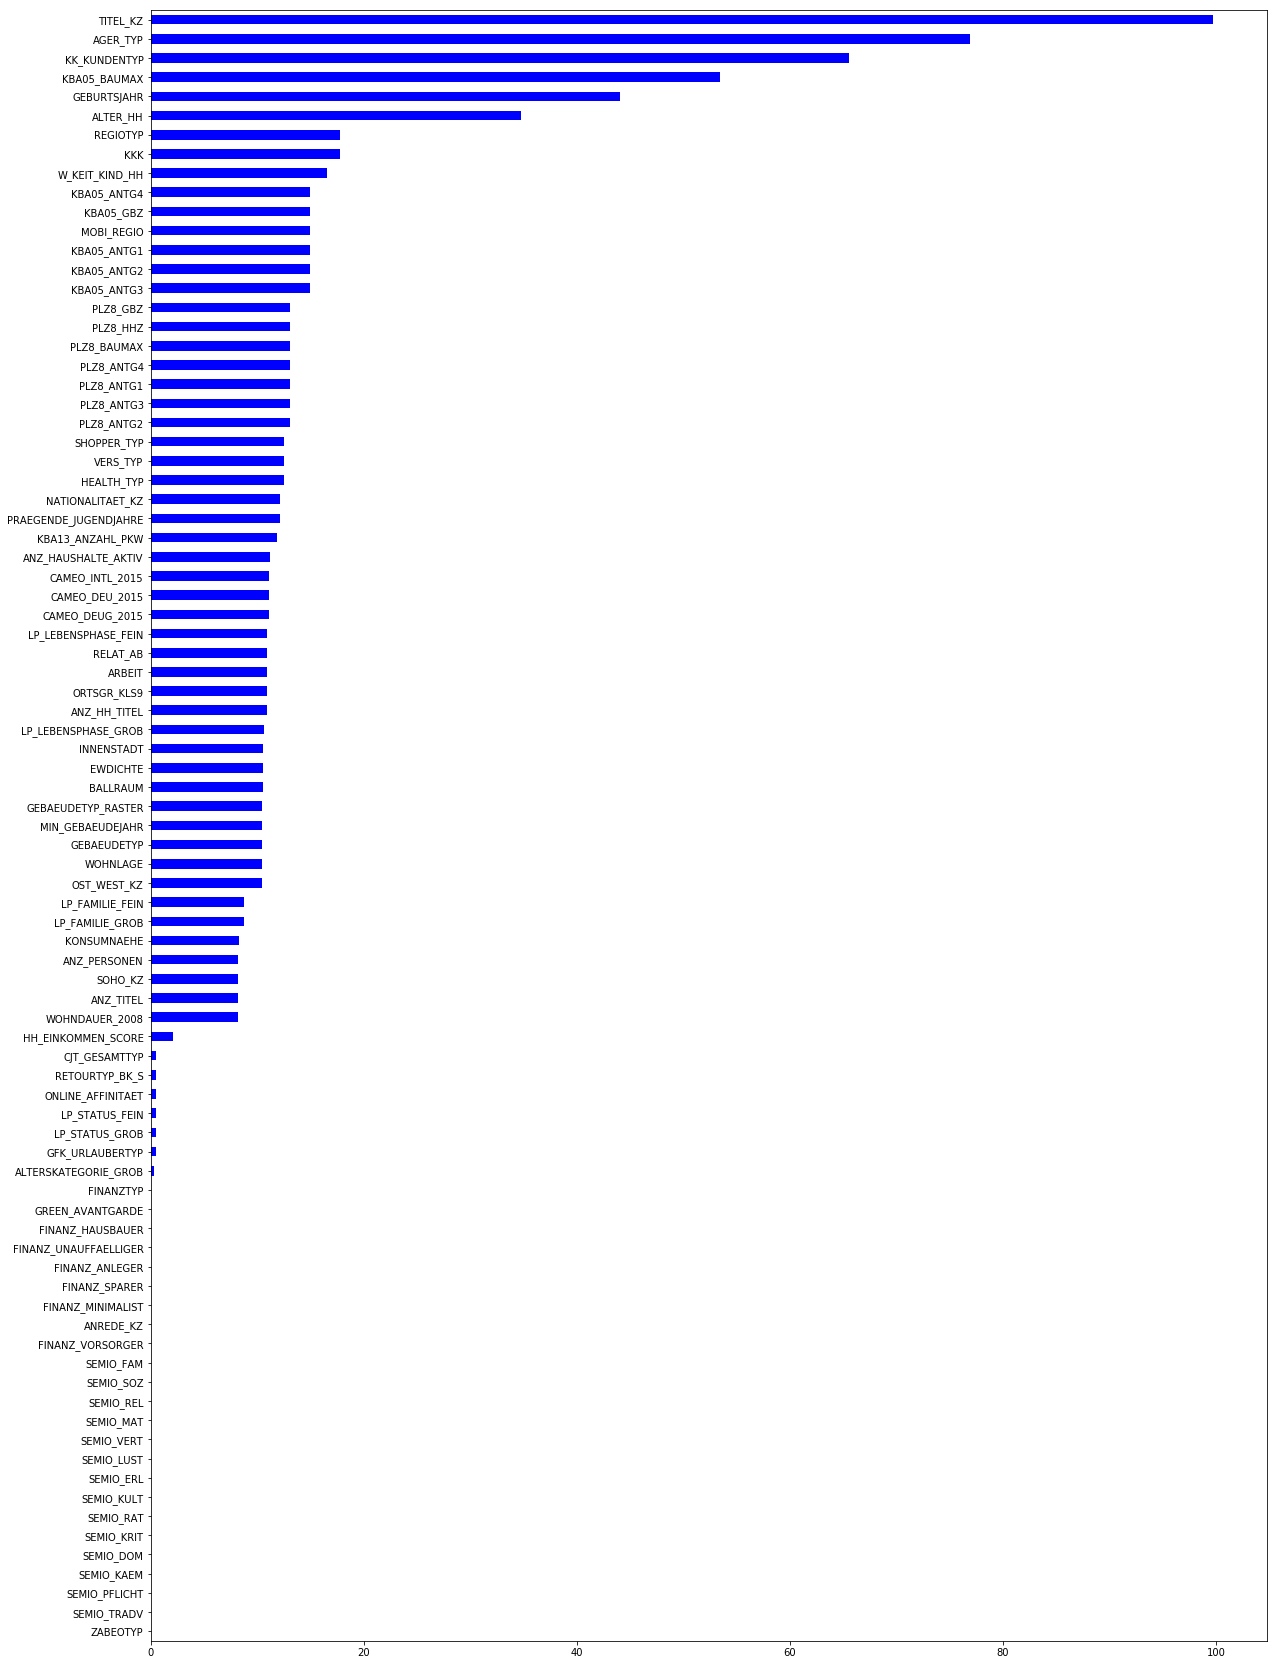

In [10]:
##Plot the percentage missing of data for each column to visually inspect low information columns.
percent_data.sort_values(ascending=True).plot.barh(figsize=(20,30),color='blue');

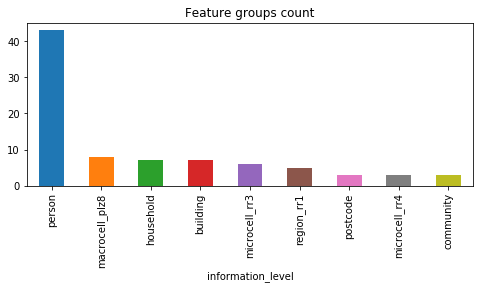

In [11]:
##Plot of Feature counts based on thier groups
feat_info.groupby('information_level').count()['type'].sort_values(ascending = False).plot(kind = 'bar', figsize = (8, 3))
plt.title('Feature groups count')
plt.show()

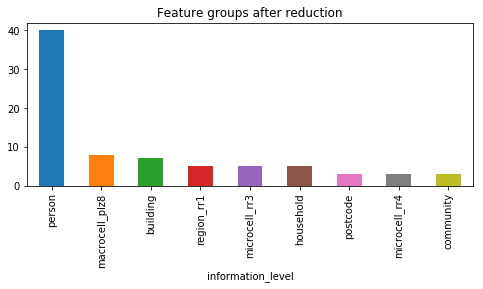

In [12]:
##Create a tuple of columns and their data missing percentage
##Use this to select columns for dropping below a certain threshold
col_missval_tup = zip(azdias.columns, (azdias.isnull().sum()*100/azdias.shape[0]).values)
#list(col_missval_tup)
drop_cols = [cols  for cols,percent in col_missval_tup if percent > 20.0]
#drop_cols

feat_info[~feat_info.attribute.isin(drop_cols)].groupby('information_level').count()['type'].sort_values(ascending = False).plot(kind = 'bar', figsize = (8, 3))
plt.title('Feature groups after reduction')
plt.show()
#drop_cols

In [13]:
print(drop_cols)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


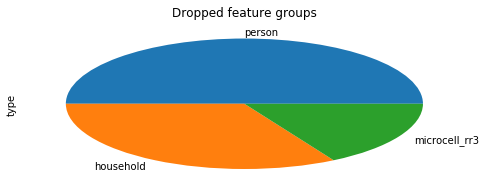

In [14]:
##Show the proportion of groups of features that will be dropped
feat_info[feat_info.attribute.isin(drop_cols)].groupby('information_level').count()['type'].sort_values(ascending = False).plot(kind = 'pie', figsize = (8, 3))
plt.title('Dropped feature groups')
plt.show()
#drop_cols

In [15]:
azdias = azdias.drop(drop_cols,axis=1)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

From the histogram plot we can see that more than 90% of the columns have good enough data (mising only 20% or less). Remaining less than 10% of the columns are missing more than 25% of the data. Considering a threshold of 20%, we can remove all columns wich have more than 20% of missing data.

We can see person, microcell_rr3, household attribute types are most in this missing category.Though person type has the highest number of features, its overall contribution remains same even after the column drop. 

#####  Some of the columns with more than 20% of data missing and selected for dropping are<br>

AGER_TYP - Person-level features <br>
TITEL_KZ - Person-level (Academic title flag)<br>
GEBURTSJAHR - Person-level (Year of birth)<br>

KK_KUNDENTYP - Household-level features(Consumer pattern over past 12 months)<br>
ALTER_HH - Household-level features (Birthdate of head of household)<br>

KBA05_BAUMAX - RR3 micro-cell features(Most common building type within the microcell)<br>


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0.5,0,'Actual Missing values in 10 bins')

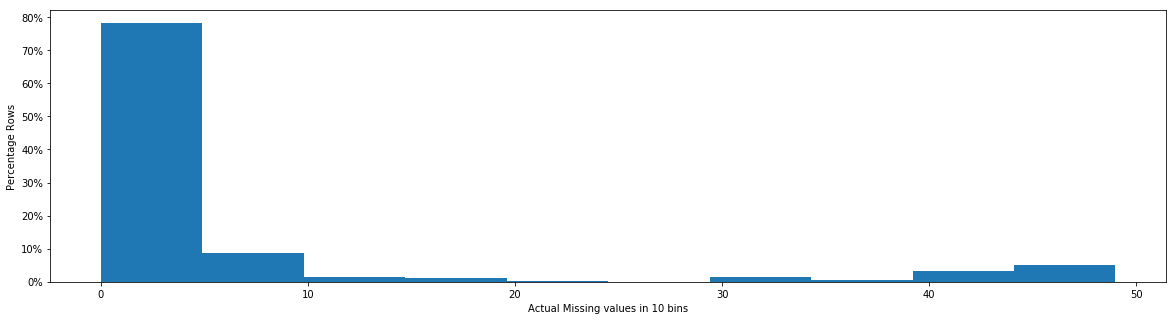

In [16]:
#missing_row_data = azdias.isnull().sum(axis=1)
#missing_row_data.value_counts
data = azdias.isnull().sum(axis=1).sort_values(ascending = False)

bins = 10
fig = plt.figure(1, (20,5))
ax = fig.add_subplot(1,1,1)
#fig,axes = plt.subplots(1,1,figsize=(24,5))
#plt.figure(figsize=(20,10))
ax.hist(data,weights = np.ones(len(data)) / len(data), bins=10)
ax.yaxis.set_major_formatter(PercentFormatter(1))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.gca.
ax.set_ylabel('Percentage Rows')
ax.set_xlabel('Actual Missing values in '+str(bins)+ " bins")

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
rows_missing_count = azdias.isnull().sum(axis = 1)
missing_high = rows_missing_count[rows_missing_count >=20]
missing_low = rows_missing_count[rows_missing_count < 20]


missing_high_df = azdias.iloc[missing_high.index,:]
missing_low_df = azdias.iloc[missing_low.index,:]
print(f"Shape of block with low missing information {missing_low_df.shape}")
print(f"Shape of block with high missing information {missing_high_df.shape}")

Shape of block with low missing information (797077, 79)
Shape of block with high missing information (94144, 79)


In [18]:
##Percentage of rows in high missing block
missing_high_df.shape[0]/(missing_low_df.shape[0] + missing_high_df.shape[0])

0.10563485375681228

In [19]:
##Percentage of rows in low missing block
missing_low_df.shape[0]/(missing_low_df.shape[0] + missing_high_df.shape[0])

0.8943651462431877

In [20]:
# How much data is missing in each row of the dataset?

def graphDataForColumn(df_missing_low, df_missing_high, colname):
    sns.set(style='whitegrid')
    f, axes = plt.subplots(1, 2,figsize=(28,5))
    sns.countplot(x = colname, data = df_missing_low, ax=axes[0])
    axes[0].set_title('Low Missing - Analysis on '+colname)
    sns.countplot(x = colname, data = df_missing_high, ax=axes[1])
    axes[1].set_title('High Missing - Analysis on '+colname)
    plt.subplots_adjust(left  = 0.5,wspace = 0.5)
    plt.show()


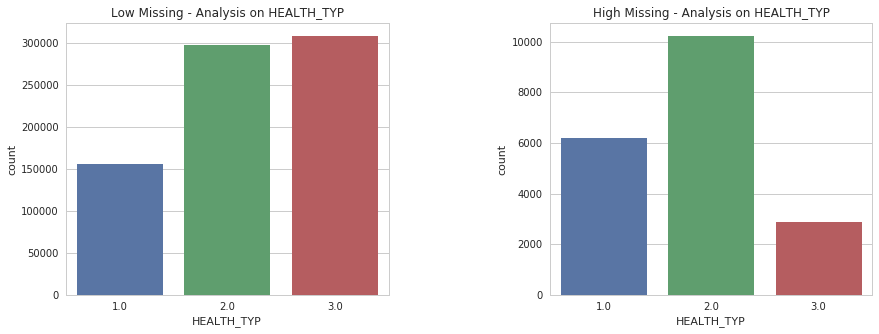

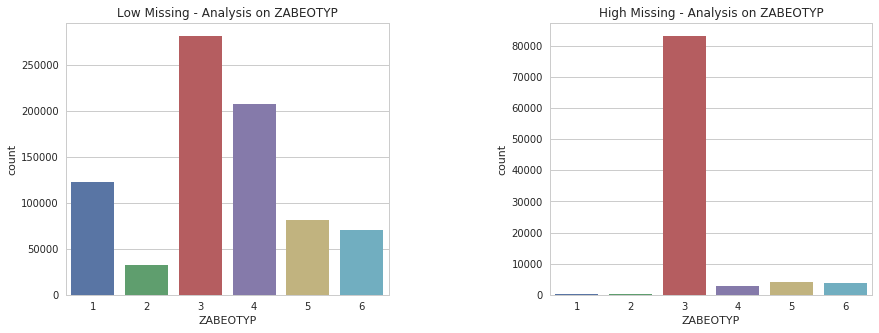

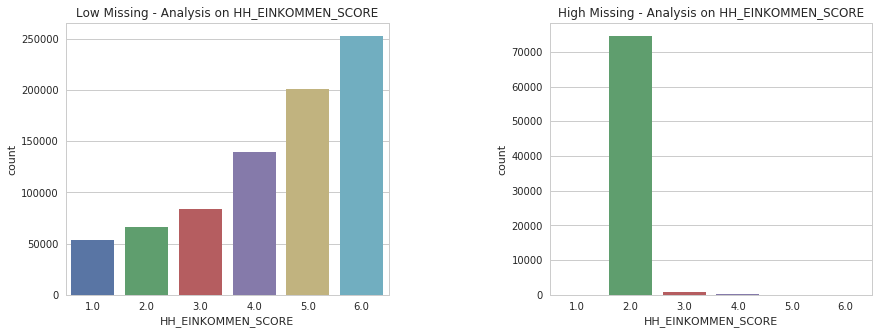

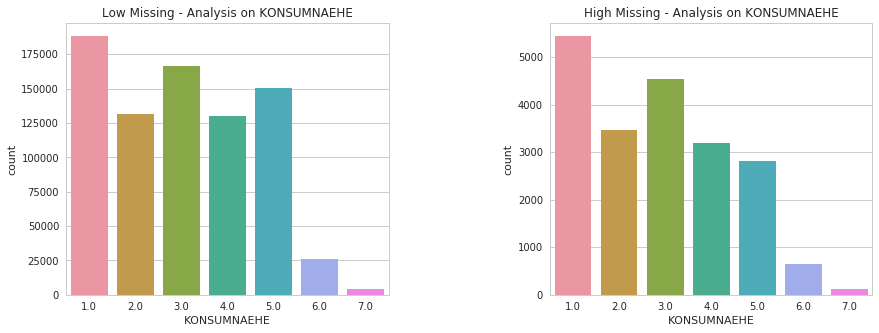

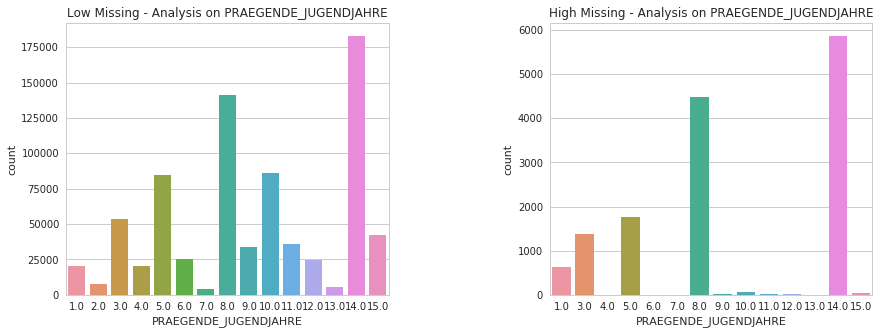

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

analyze_cols = ['HEALTH_TYP','ZABEOTYP','HH_EINKOMMEN_SCORE','KONSUMNAEHE','PRAEGENDE_JUGENDJAHRE']
for col in analyze_cols:
    graphDataForColumn(missing_low_df, missing_high_df,col)


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Comparing few of the categorical columns we can clearly see the values in the missing_high category are of low information quality. Most of the columns have only some of the categories represented and those that are represented are significantly less than the ones shown on the left side.

Also we can see that the distribution of values within a column is very different on both the datasets, the intra column variance is not the same in both the cases.

As these are categorical columns, computing a value to be imputed is trickier than a numerical features.As it is not straight forward to derermine a mean, inserting value of most frequent category might inadvertently introduce bias.

Considering above, we can drop the rows of high_missing dataset as it only contains 10% of the overall number of records.



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

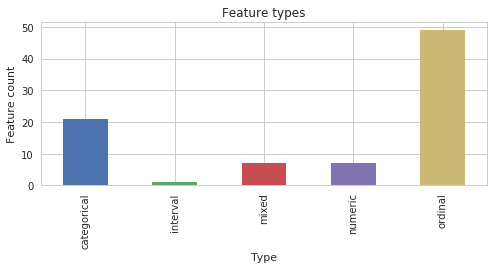

In [22]:
# How many features are there of each data type?
ax = feat_info.groupby(['type']).size().plot(kind = 'bar', figsize = (8, 3))
ax.set_xlabel("Type")
ax.set_ylabel("Feature count")
plt.title('Feature types')
plt.show()

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
feat_info.query('type == "categorical"').attribute
#feat_info

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

##Since some of the columns have been dropped, we are now analyzing the remaining columns only

type_categories = feat_info.groupby('type').size().index
for cat in type_categories:
    if cat == 'categorical':
        cat_features = feat_info.query('type ==@cat').attribute
        cat_features_current = [f for f in cat_features if f in azdias.columns]

azdias[cat_features_current].apply(lambda x: print(x.name, '->', x.unique()));

ANREDE_KZ -> [1 2]
CJT_GESAMTTYP -> [2.0 5.0 3.0 4.0 1.0 6.0 nan]
FINANZTYP -> [4 1 6 5 2 3]
GFK_URLAUBERTYP -> [10.0 1.0 5.0 12.0 9.0 3.0 8.0 11.0 4.0 2.0 7.0 6.0 nan]
GREEN_AVANTGARDE -> [0 1]
LP_FAMILIE_FEIN -> [2.0 5.0 1.0 nan 10.0 7.0 11.0 3.0 8.0 4.0 6.0 9.0]
LP_FAMILIE_GROB -> [2.0 3.0 1.0 nan 5.0 4.0]
LP_STATUS_FEIN -> [1.0 2.0 3.0 9.0 4.0 10.0 5.0 8.0 6.0 7.0 nan]
LP_STATUS_GROB -> [1.0 2.0 4.0 5.0 3.0 nan]
NATIONALITAET_KZ -> [nan 1.0 3.0 2.0]
SHOPPER_TYP -> [nan 3.0 2.0 1.0 0.0]
SOHO_KZ -> [nan 1.0 0.0]
VERS_TYP -> [nan 2.0 1.0]
ZABEOTYP -> [3 5 4 1 6 2]
GEBAEUDETYP -> [nan 8.0 1.0 3.0 2.0 6.0 4.0 5.0]
OST_WEST_KZ -> [nan 'W' 'O']
CAMEO_DEUG_2015 -> [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 -> [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


#### Features with non numerical values are OST_WEST_KZ and CAMEO_DEU_2015 

In [25]:
##Removing the high missing part of the dataset
azdias = missing_low_df
print(azdias.shape)

(797077, 79)


In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
dropcols = ['CAMEO_DEU_2015','LP_STATUS_FEIN','LP_FAMILIE_FEIN','GEBAEUDETYP']
#drop_cols_collector = drop_cols_collector + dropcols
azdias = azdias.drop(dropcols,axis=1)
onehot_encode = [f for f in cat_features_current if (f not in dropcols and f != 'OST_WEST_KZ')]
#onehot_encode
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 0})

azdias = pd.get_dummies(azdias, columns=onehot_encode, dummy_na = True)
print(azdias.shape)
azdias.head()

(797077, 139)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,0,0,0,0,0,0,0,1,0,0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,0,0,0,1,0,0,0,0,0,0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,0,0,0,0,0,1,0,0,0,0
5,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,0,0,0,0,0,0,0,1,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Of the list of categorical features present, the values present in each one was analyzed.

ANREDE_KZ - Gender<br>
CJT_GESAMTTYP - Preferred information and buying channel<br>
FINANZTYP - Most descriptive financial type for individual<br>
GFK_URLAUBERTYP - Vacation habits<br>
LP_FAMILIE_FEIN - Family fine scale<br>
LP_FAMILIE_GROB - Family rough scale<br>
LP_STATUS_FEIN - Social status Fine<br>
LP_STATUS_GROB - Social status Rough<br>
NATIONALITAET_KZ - Nationality based on Name<br>
VERS_TYP - Insurance typology<br>
ZABEOTYP - Energy consumption<br>
GEBAEUDETYP - Type of building<br>
OST_WEST_KZ - Building location, east or west<br>
CAMEO_DEUG_2015 - Wealth / Life Stage Rough<br>
CAMEO_DEU_2015  - Wealth / Life Stage Fine<br>

Some of the features are finer versions of existing features (Rough vs Fine). Since Rough already captures high level information with less values, we will be dropping the finer versions.
##### Drop finer features
CAMEO_DEU_2015  - Wealth / Life Stage Fine<br>
LP_STATUS_FEIN - Social status FIne<br>
LP_FAMILIE_FEIN - Family fine scale<br>

Also on analysis of the data captured, some features I feel do not directly impact the customer segmentation task.
GEBAEUDETYP - Gives details of individuals building type.
##### Drop irrelevantt features
GEBAEUDETYP

Maintaining the rest of features by applying one hot encoding. For OST_WEST_KZ apply a map to convert this to numeric. Maintaining this feature as there is still a economic disparity between the East and West Germany.Though there is significant improvement since reunification, there is still a clear income gap between areas of former West and East Germany [Reference](https://www.thelocal.de/20181002/the-east-west-divide-is-diminishing-but-differences-still-remain)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
## Mixed type of features are
type_categories = feat_info.groupby('type').size().index
for cat in type_categories:
    if cat == 'mixed':
        mxd_features = feat_info[feat_info['type'] == cat].attribute
        mxd_features_current = [f for f in mxd_features if f in azdias.columns]

azdias[mxd_features_current].apply(lambda x: print(x.name, '->', x.unique()));

LP_LEBENSPHASE_FEIN -> [21.0 3.0 nan 32.0 8.0 2.0 5.0 10.0 4.0 6.0 23.0 12.0 20.0 1.0 11.0 25.0
 13.0 18.0 31.0 38.0 35.0 30.0 7.0 22.0 14.0 29.0 24.0 28.0 37.0 26.0 39.0
 27.0 36.0 9.0 34.0 33.0 15.0 40.0 16.0 19.0 17.0]
LP_LEBENSPHASE_GROB -> [6.0 1.0 nan 10.0 2.0 3.0 5.0 7.0 12.0 11.0 9.0 4.0 8.0]
PRAEGENDE_JUGENDJAHRE -> [14.0 15.0 8.0 3.0 10.0 11.0 5.0 9.0 6.0 4.0 nan 2.0 1.0 12.0 13.0 7.0]
WOHNLAGE -> [4.0 2.0 7.0 3.0 5.0 1.0 8.0 0.0]
CAMEO_INTL_2015 -> ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']
PLZ8_BAUMAX -> [1.0 2.0 nan 4.0 5.0 3.0]


In [28]:
def getGeneration(val):
    if pd.isnull(val):
        #print("In else case")
        return np.nan, np.nan
    else:
        if val in[1,2]:
            gen="Fourtys"
            if val == 1:
                mov=0
            else:
                mov=1
        if val in[3,4]:
            gen = "Fiftys"
            if val == 3:
                mov=0
            else:
                mov=1
        if val in[5,6,7]:
            gen = "Sixtys"
            if val == 5:
                mov=0
            else:
                mov=1
        if val in[8,9]:
            gen = "Seventys"
            if val== 8:
                mov=0
            else:
                mov=1
        if val in[10,11,12,13]:
            gen = "Eightys"
            if val in [10,12]:
                mov=0
            else:
                mov=1
        if val in[14,15]:
            gen = "Ninetys"
            if val == 14 :
                mov=0
            else:
                mov=1
        return gen,mov

In [29]:
print(f"Start time {datetime.datetime.now()}")
#azdias[z] = df.apply(lambda row: row.y if row.PRAEGENDE_JUGENDJAHRE else row.x, axis=1)
azdias['GENERATION'],azdias['MOVEMENT'] = zip(*azdias['PRAEGENDE_JUGENDJAHRE'].map(getGeneration))
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda x : x if pd.isnull(x) else float(x)//10 )
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(lambda x :x if pd.isnull(x) else float(x)%10)
print(f"End time   {datetime.datetime.now()}")
#azdias['GENERATION'],azdias['MOVEMENT'] = zip(*azdias.applymap(getGeneration), axis=1)

Start time 2019-03-26 01:52:05.024010
End time   2019-03-26 01:52:09.619849


In [30]:
print(azdias.shape)
azdias = pd.get_dummies(azdias, columns=['GENERATION'], dummy_na = True)
print(azdias.shape)

(797077, 143)
(797077, 149)


Investigate "CAMEO_INTL_2015" and engineer two new variables.<br>
The values in the column encode two main information, the unit place holds FamilyType and the tenth place holds informaton on financial health.
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples



In [31]:
##azdias['EARNERS'] = azdias['LP_LEBENSPHASE_GROB'].apply(lambda x : x if pd.isnull(x) else 0 if x in [1,2,3,4,5,6,7] else 1)
#deciding to drop LP_LEBENSPHASE_GROB as the type of family is alrady captured in LP_FAMILIE_GROB

###New columns encoding the NaN values are also created,these can be dropped

nan_encoded_cols = [col  for col in azdias.columns if "nan" in col]
nan_encoded_cols

azdias = azdias.drop(nan_encoded_cols,axis=1)
azdias.shape

(797077, 135)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The six mixed type of features were analyzed in detail, will engineers new features using PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. After creating new features the source features will be dropped.

Also dropping WOHNLAGE,PLZ8_BAUMAX since it captures neighbhourhod types which is alread captured by REGIOTYP.

Dropping LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB as the family type is alredy captured under LP_FAMILIE_GROB


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [32]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [33]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_features_drop = mxd_features_current
azdias = azdias.drop(mixed_features_drop,axis=1)
azdias.shape


(797077, 129)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [34]:
def clean_data(df,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
   
    df = repalce_missing_with_NAN(feat_info,df)
    percent_data = (df.isnull().sum()/df.shape[0])*100
    
    drop1 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(drop1,axis=1)
    rows_missing_count = df.isnull().sum(axis = 1)
    missing_high = rows_missing_count[rows_missing_count >=20]
    missing_low = rows_missing_count[rows_missing_count < 20]
    missing_high_df = df.iloc[missing_high.index,:]
    missing_low_df = df.iloc[missing_low.index,:]
    print(f"Shape of block with low missing information {missing_low_df.shape}")
    print(f"Shape of block with high missing information {missing_high_df.shape}")
    #print(missing_low)
    # select, re-encode, and engineer column values.
    df = missing_low_df
    type_categories = feat_info.groupby('type').size().index
    for cat in type_categories:
        if cat == 'categorical':
            cat_features = feat_info[feat_info['type'] == cat].attribute
            cat_features_current = [f for f in cat_features if f in df.columns]
        
    drop2 = ['CAMEO_DEU_2015','LP_STATUS_FEIN','LP_FAMILIE_FEIN','GEBAEUDETYP']
    df = df.drop(drop2,axis=1)
    onehot_encode = [f for f in cat_features_current if (f not in dropcols and f != 'OST_WEST_KZ')]
    
    #onehot_encode
    print(f"Ater one hot encode...shape")
    print(df.shape)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    
    df = pd.get_dummies(df, columns=onehot_encode, dummy_na = True)
    print(f"The dataframe shape after removing and one-hot encoding columns -> {df.shape}")
    
    
    for cat in type_categories:
        if cat == 'mixed':
            mxd_features = feat_info[feat_info['type'] == cat].attribute
            mxd_features_current = [f for f in mxd_features if f in df.columns]

    df['GENERATION'],df['MOVEMENT'] = zip(*df['PRAEGENDE_JUGENDJAHRE'].map(getGeneration))
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x : x if pd.isnull(x) else float(x)//10 )
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x :x if pd.isnull(x) else float(x)%10)
    
    df = pd.get_dummies(df, columns=['GENERATION'], dummy_na = True)
    
    
    ###New columns encoding the NaN values are also created,these can be dropped
    nan_encoded_cols = [col  for col in df.columns if "nan" in col]
    
    #print(f"NAN drop {nan_encoded_cols}")
    df = df.drop(nan_encoded_cols,axis=1)
    
    mixed_features_drop = mxd_features_current
    df = df.drop(mixed_features_drop,axis=1)
    print(f"The dataframe shape after handling mixed columns -> {df.shape}")
    # Return the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [35]:
type_categories = feat_info.groupby('type').size().index
for cat in type_categories:
    if cat == 'numeric':
        features = feat_info[feat_info['type'] == cat].attribute
        features_current = [f for f in features if f in azdias.columns]

azdias[features_current].apply(lambda x: print(x.name, '->', x.unique()));

ANZ_PERSONEN -> [  2.   1.   0.   4.   3.   5.   6.   7.   8.  12.   9.  21.  10.  13.  11.
  14.  45.  20.  31.  37.  16.  22.  15.  23.  18.  35.  17.  40.  38.]
ANZ_TITEL -> [ 0.  1.  2.  4.  3.]
ANZ_HAUSHALTE_AKTIV -> [  11.   10.    1.    3.    5.    4.    6.    2.    9.   nan   14.   13.
    8.    7.   44.   25.   36.   16.  272.   33.   15.   12.   22.   21.
   20.   67.   23.   18.   27.   24.   31.   39.   19.   30.   17.   29.
   61.   54.   88.   49.   60.   38.   34.   48.   35.   62.   26.   45.
   42.   28.   77.   47.   50.  236.  137.   43.   52.   41.   76.   63.
   32.   40.   37.   59.   53.   57.  118.   66.   95.   78.   70.   46.
  185.   73.  154.   80.  102.   92.  126.   94.   71.   68.   81.   69.
  121.  258.   58.   86.  124.   85.   90.  128.   51.   72.   64.   56.
   83.  150.  259.   91.  160.  134.  169.  246.   82.  114.  183.  116.
   74.  143.   99.  216.   98.  125.  112.  123.   55.  120.   75.  141.
  103.   87.   89.  223.   93.  179.  135.  149.

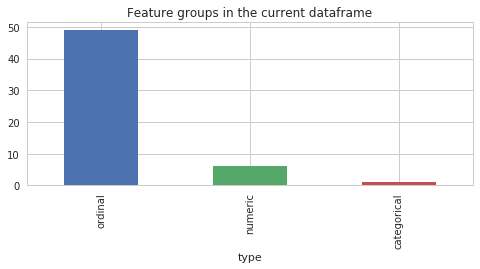

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

feat_info[feat_info.attribute.isin(azdias.columns)].groupby('type').count()['attribute'].sort_values(ascending = False).plot(kind = 'bar', figsize = (8, 3))
plt.title('Feature groups in the current dataframe')
plt.show()



In [37]:
##from sklearn.compose import ColumnTransformer, make_column_transformer
##Separate columns based on the impute strategy
'''
type_categories = feat_info.groupby('type').size().index
for cat in type_categories:
   if cat == 'categorical':
        features = feat_info[feat_info['type'] == cat].attribute
        features_current_cat = [f for f in features if f in azdias.columns]
    elif cat == 'numeric':
        features_num = feat_info[feat_info['type'] == cat].attribute
        features_current_num = [f for f in features_num if f in azdias.columns]
print(features_current_cat)
print(features_current_num) '''

"\ntype_categories = feat_info.groupby('type').size().index\nfor cat in type_categories:\n   if cat == 'categorical':\n        features = feat_info[feat_info['type'] == cat].attribute\n        features_current_cat = [f for f in features if f in azdias.columns]\n    elif cat == 'numeric':\n        features_num = feat_info[feat_info['type'] == cat].attribute\n        features_current_num = [f for f in features_num if f in azdias.columns]\nprint(features_current_cat)\nprint(features_current_num) "

In [38]:
azdias_tmp = azdias

In [39]:
azdias.FINANZ_VORSORGER.max()

5

In [40]:
#azdias.ALTERSKATEGORIE_GROB.max
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       ...
       'CAMEO_DEUG_2015_9', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE',
       'GENERATION_Eightys', 'GENERATION_Fiftys', 'GENERATION_Fourtys',
       'GENERATION_Ninetys', 'GENERATION_Seventys', 'GENERATION_Sixtys'],
      dtype='object', length=129)

In [41]:
##Impute values
print(azdias.shape)
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
#azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias))
azdias_imputed = imputer.fit_transform(azdias)
azdias_imputed_df = pd.DataFrame(azdias_imputed, columns =azdias.columns )
print(azdias_imputed_df.shape)
#print(azdias_imputed.columns)

(797077, 129)
(797077, 129)


In [42]:
# Apply feature scaling to the general population demographics data.
##Scale the columns
scalar = StandardScaler()
azdias_scaled_df = pd.DataFrame(scalar.fit_transform(azdias_imputed),columns =azdias.columns )


In [43]:
azdias_scaled_df.LIFE_STAGE.max()

1.4387114495561102

### Discussion 2.1: Apply Feature Scaling

The existing columns were analyzed, we could see there are 7 numeric columns and the rest being ordinal and categorical data after one hot encoding.

Since the majority of the columns are categorical or its derivative, we can use the most_frequent value as the imputation strategy. This can take care of values of both the types.

If there are large number of numeric features, then we can attempt to use mean or median values.By identifying the columns we can apply different impute strategies based on the values in the columns.Either using the new features in sklearn like ColumnTransformer or build separate dataframes with subset of columns and later concat it.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.

#pca = PCA(n_components = 80, random_state=20)
pca = PCA(random_state=20)
azdias_pca_model = pca.fit(azdias_scaled_df.values)
azdias_pca = azdias_pca_model.transform(azdias_scaled_df.values)
#pca.

In [83]:
pca.explained_variance_ratio_
pca.components_.shape

(80, 129)

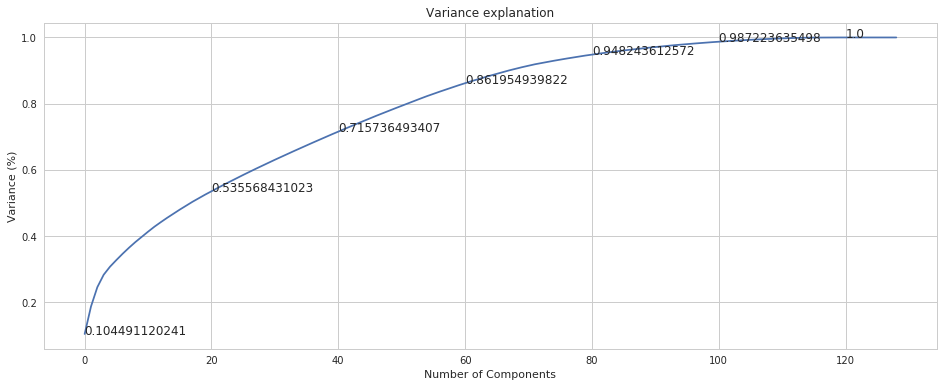

In [45]:
# Investigate the variance accounted for by each principal component.
#Plotting the Cumulative Summation of the Explained Variance
fig  = plt.figure(figsize = (16,6))
ax = fig.add_subplot(111)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Variance explanation')
for i,j in zip(np.arange(pca.n_components_),pca.explained_variance_ratio_):
    
    if i%20 == 0:
        ax.annotate(np.cumsum(pca.explained_variance_ratio_)[i],xy=(i,np.cumsum(pca.explained_variance_ratio_)[i]))
#ax.annotate("0.8484350620262654",xy=(80,0.9408234518014351))
plt.show()


In [85]:
# Re-apply PCA to the data while selecting for number of components to retain.
##Selecting components as 80 explaining more than 94% of variance
pca = PCA(n_components = 60, random_state=20)
azdias_pca_model = pca.fit(azdias_scaled_df.values)
azdias_pca = azdias_pca_model.transform(azdias_scaled_df.values)


### Discussion 2.2: Perform Dimensionality Reduction

On analyzing the explained variance, we cann see that more than 94% variance is explained with 80 components of the dataset.
Selecting this value to train the pca model.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [86]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#pca.components_.shape
components_df = pd.DataFrame(pca.components_, columns = azdias_scaled_df.columns)
components_df.head()
#components_df.shape

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEUG_2015_9,MOVEMENT,WEALTH,LIFE_STAGE,GENERATION_Eightys,GENERATION_Fiftys,GENERATION_Fourtys,GENERATION_Ninetys,GENERATION_Seventys,GENERATION_Sixtys
0,-0.127474,-0.215537,0.158704,-0.125000,0.093982,0.091005,0.141053,0.043127,-0.036533,0.031353,...,0.113519,-0.115577,0.180890,-0.113825,0.010652,-0.049468,-0.026308,0.104567,-0.034256,-0.066127
1,0.213247,0.035152,-0.196830,0.199666,-0.175581,-0.201478,0.125620,-0.045169,0.147572,-0.079011,...,0.043777,-0.039079,0.095633,-0.015279,-0.054269,0.095529,0.061720,-0.183453,0.058027,0.104300
2,0.045431,0.118348,-0.072099,0.069681,-0.157808,-0.072402,-0.031456,-0.016556,0.089516,0.238324,...,0.031023,0.041994,0.041167,-0.021322,-0.007898,0.038288,0.019647,-0.060031,0.010723,0.041455
3,-0.032099,0.008689,0.008147,-0.018328,-0.085754,0.065929,-0.033593,-0.007914,-0.000997,-0.004849,...,-0.008231,0.345185,-0.059190,0.028769,0.037669,-0.003828,-0.002234,0.023582,-0.032264,-0.017053
4,0.031169,0.121147,-0.032360,-0.008008,0.023139,-0.121864,-0.177586,0.076259,0.031277,-0.002579,...,0.059873,-0.056535,0.059239,-0.056668,0.166402,-0.076732,-0.065547,-0.125205,0.141873,-0.065072


In [87]:
pca.explained_variance_ratio_

array([ 0.10449112,  0.08302735,  0.05828281,  0.0375871 ,  0.0243475 ,
        0.02001368,  0.01923472,  0.01810691,  0.01700715,  0.0157034 ,
        0.01562936,  0.01500897,  0.01362898,  0.0131306 ,  0.01261942,
        0.01228574,  0.01193261,  0.01161149,  0.01093878,  0.01070202,
        0.01027161,  0.01018568,  0.01005173,  0.009774  ,  0.00963564,
        0.00956782,  0.00940224,  0.00929543,  0.00912057,  0.00907616,
        0.00893049,  0.00883315,  0.00869591,  0.00868948,  0.00865444,
        0.00853279,  0.0084435 ,  0.00843097,  0.0083204 ,  0.00827194,
        0.00814402,  0.00809386,  0.00806497,  0.00802325,  0.00789686,
        0.00781352,  0.00771827,  0.00760341,  0.00752798,  0.00748446,
        0.00739925,  0.00736206,  0.00733617,  0.00732063,  0.00716453,
        0.00681103,  0.00661345,  0.00652956,  0.00644832,  0.00629594])

In [88]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def displayVarianceExplanation_Features(components_df, n_components, n_features,multicomp=True):
    
    '''
    components_df - The components matrix from the pca model (components * Actual columns)
    n_components - The components to be analyzed
    n_features - The features to be analyzed for each component
    multicomp - Flag to identify if the analysis is for multiple components or one specific component.
    
    '''
    
    if multicomp:
        for i in range(n_components):
            fig, ax = plt.subplots(1, 2,figsize=(24,5))
            components_df.iloc[i].sort_values(ascending = False)[:n_features].plot.bar(ax=ax[0],color='blue' )
            components_df.iloc[i].sort_values(ascending = False)[-n_features:].plot.bar(ax=ax[1],color='red' )
            plt.subplots_adjust(left  = 0.5,wspace = 0.5)
            ax[0].set_title('High Relevence Features - PC'+str(i+1))
            ax[1].set_title('Low Relevence Features - PC'+str(i+1))
            plt.show()
    else:
        
        fig, ax = plt.subplots(1, 2,figsize=(24,5))
        components_df.iloc[n_components].sort_values(ascending = False)[:n_features].plot.bar(ax=ax[0],color='blue' )
        components_df.iloc[n_components].sort_values(ascending = False)[-n_features:].plot.bar(ax=ax[1],color='red' )
        plt.subplots_adjust(left  = 0.5,wspace = 0.5)
        ax[0].set_title('High Relevence Features for this PC')
        ax[1].set_title('Low Relevence Features for this PC')
        plt.show()            


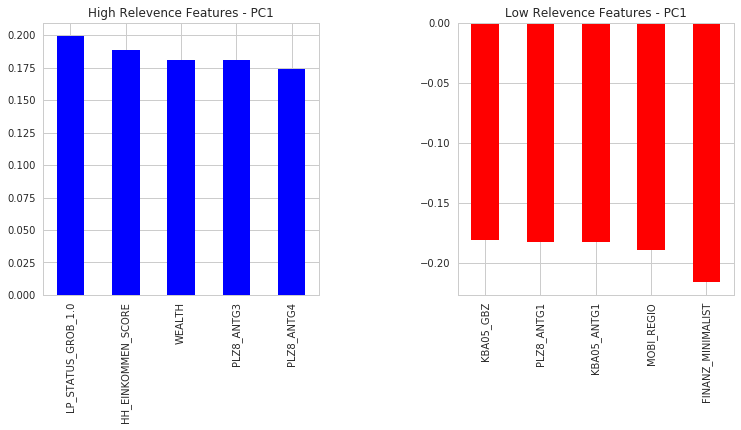

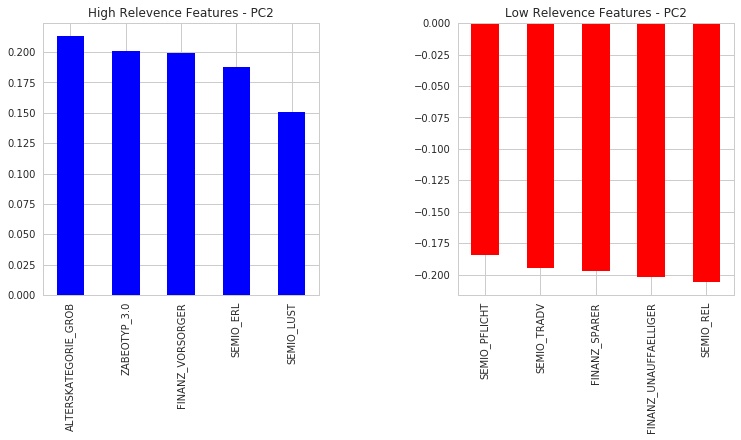

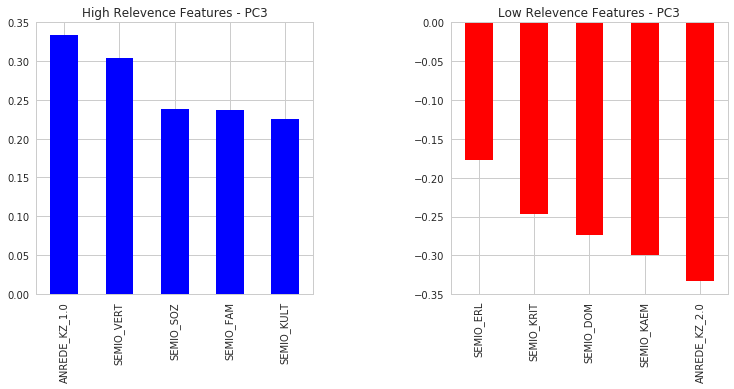

In [89]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
displayVarianceExplanation_Features(components_df,3,5,multicomp=True)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [51]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    
    # compute the average within-cluster distances.
    
def findKMeansClusters(centroids):
    
    kmeans_score = []
    for i in centroids:
        print(f"start of kmeans for cluster {i}")
        kmeans = KMeans(i,random_state=13,max_iter=250)
        kmeans.fit(azdias_pca)
        kmeans_score.append(-kmeans.score(azdias_pca))
        #print("The score is {i}")
    return kmeans_score
    

In [52]:
###Kmeans score calculated has been dumped as a pickle file.Loading scores from disk as compute time is very high.
with open('kmeanscore.pkl', 'rb') as f:
    kmeans_score = pickle.load(f)
centroids = [2,4,6,7,9,11,14,16,18,21,23,25,27,28,30]

In [53]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
'''
centroids = [2,4,6,7,9,11,14,16,18,21,23,25,27,28,30]
print(f"Start time {datetime.datetime.now()}")
kmeans_score = findKMeansClusters(centroids)
print(f"End time {datetime.datetime.now()}")
kmeans_score'''

'\ncentroids = [2,4,6,7,9,11,14,16,18,21,23,25,27,28,30]\nprint(f"Start time {datetime.datetime.now()}")\nkmeans_score = findKMeansClusters(centroids)\nprint(f"End time {datetime.datetime.now()}")\nkmeans_score'

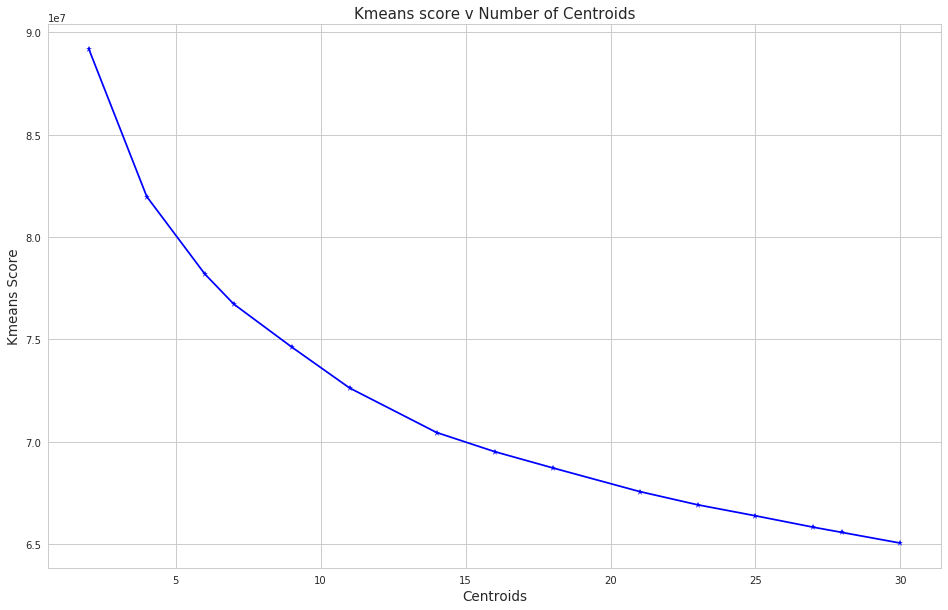

In [54]:
fig = plt.subplots(figsize=(16,10))
ax = plt.subplot(111)
plt.plot(centroids,kmeans_score,linestyle='-',marker='*',color='blue')

ax.set_xlabel('Centroids', fontsize=13.5)
ax.set_ylabel('Kmeans Score', fontsize=13.5)
plt.title('Kmeans score v Number of Centroids',fontsize=15);

In [55]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_selected = KMeans(16,random_state=13,max_iter=250)
kmeans_selected.fit(azdias_pca)
#-kmeans.score(azdias_pca) 
azdias_imputed_df['clusters'] = kmeans_selected.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Considering the plot of the centroids vs K score we can see there is not a easily identifiable elbow point to be selected. It can be eaither of the values 14,16 or 21.

Selecting 16 as the number of clusters and continuing.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [56]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
customers.shape

(191652, 85)

In [57]:
## Apply clean data method to customer dataset
customers_cleaned = clean_data(customers,feat_info)

Shape of block with low missing information (141590, 79)
Shape of block with high missing information (50062, 79)
Ater one hot encode...shape
(141590, 75)
The dataframe shape after removing and one-hot encoding columns -> (141590, 139)
The dataframe shape after handling mixed columns -> (141590, 129)


In [58]:
##Verify if the columns indentified for customers data is same as that for azdias dataset.
if len(azdias.columns) == len([f for f in customers_cleaned.columns if f in azdias.columns ]):
    print(f"Same columns present")
else:
    print(f"Different columns present")

Same columns present


In [59]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_imp = imputer.transform(customers_cleaned)
customers_imp_df = pd.DataFrame(customers_imp, columns=customers_cleaned.columns )
customers_scld = scalar.transform(customers_imp)
customers_pca = azdias_pca_model.transform(customers_scld)
#customers_pca = pd.DataFrame(customers_imp, columns = customers_cleaned.columns)
customers_pca.shape

(141590, 80)

In [60]:
customer_clust = kmeans_selected.predict(customers_pca)
customers_imp_df['clusters'] = customer_clust
np.unique(customer_clust)
##len(kmeans_selected.cluster_centers_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int32)

##### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [61]:
#azdias_imputed_df.groupby(['clusters']).count()['ALTERSKATEGORIE_GROB'].to_frame(name = 'count_azdias')
df_cust = customers_imp_df.groupby(['clusters']).count()['ALTERSKATEGORIE_GROB'].to_frame(name = 'count_cust')
df_azdias = azdias_imputed_df.groupby(['clusters']).count()['ALTERSKATEGORIE_GROB'].to_frame(name = 'count_azdias')
combined_clust_df = pd.concat([df_cust,df_azdias], axis=1)
combined_clust_df['cluster'] = combined_clust_df.index+1
cust_sum = combined_clust_df.count_cust.sum()
azdias_sum = combined_clust_df.count_azdias.sum()
combined_clust_df['cust_percent'] = combined_clust_df.count_cust.apply(lambda x : x*100/cust_sum)
combined_clust_df['azdias_percent'] = combined_clust_df.count_azdias.apply(lambda x : x*100/azdias_sum)
combined_clust_df['difference'] = combined_clust_df.cust_percent - combined_clust_df.azdias_percent
combined_clust_df.head(16)

,count_cust,count_azdias,cluster,cust_percent,azdias_percent,difference
clusters,,,,,,
0,3757,57629,1,2.653436,7.230042,-4.576606
1,9801,49342,2,6.922099,6.190368,0.731731
2,2574,20062,3,1.817925,2.516946,-0.699021
3,13504,47534,4,9.537397,5.963539,3.573857
4,4138,44998,5,2.922523,5.645377,-2.722854
5,45403,53686,6,32.066530,6.735359,25.331171
6,16149,53422,7,11.405466,6.702238,4.703228
7,1390,6707,8,0.981708,0.841449,0.140258
8,1337,46137,9,0.944276,5.788274,-4.843998


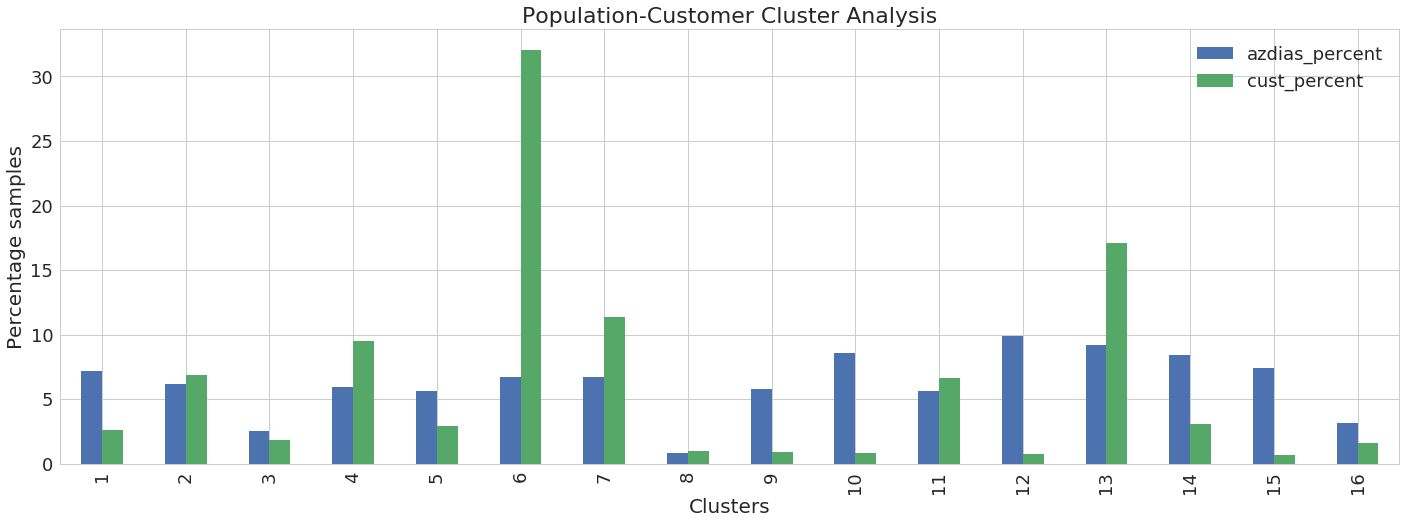

In [62]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
ax = combined_clust_df.plot(x="cluster", y=["azdias_percent", "cust_percent"], kind="bar",figsize=(24,8), title='Population-Customer Cluster Analysis',fontsize=18)
ax.set_xlabel("Clusters",fontsize=20)
ax.set_ylabel("Percentage samples",fontsize=20)
ax.title.set_size(22)
ax.legend(prop={'size': 18});


In [63]:
#kmeans_selected.cluster_centers_[5]
cluster_series = pd.Series(kmeans_selected.cluster_centers_[5])
#print(np.argpartition(kmeans_selected.cluster_centers_[5], -4)[-4:].tolist().reverse())
cluster_series.sort_values(ascending=False)[:10]

2     3.074307
3     2.864383
26    0.296707
66    0.250015
63    0.244239
21    0.234369
35    0.223681
14    0.204385
9     0.178303
43    0.168214
dtype: float64

In [64]:
##Using the cluster center ( a point in the high dimensional space) we can see which of the dimensions contributes the highest.
### Since each dimension is a component of the PCA model, this highest contributor to the centroid point must be the principal component of this point.

##Need verification of the above statement!!!

cluster_series = pd.Series(azdias_pca_model.inverse_transform(kmeans_selected.cluster_centers_[5]))
#cluster_series.index = cluster_series.index
cluster_series.sort_values(ascending=False)[:10]


83     1.871002
120    1.871002
93     1.826675
1      1.271661
105    1.131862
13     1.030742
56     0.996193
33     0.909899
43     0.863179
68     0.770727
dtype: float64

In [65]:
### Continuing over-representation analysis with cluster 12
cluster_series_12 = pd.Series(kmeans_selected.cluster_centers_[12])
#cluster_series.index = cluster_series.index
cluster_series_12.sort_values(ascending=False)[:10]

2     1.865936
4     0.539275
18    0.472940
11    0.347343
15    0.320143
13    0.270157
9     0.236445
54    0.200448
12    0.194568
62    0.192806
dtype: float64

In [66]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
#azdias_pca_model.inverse_transform(kmeans_selected.cluster_centers_[5])[:10]
#kmeans_selected.cluster_centers_[5]
displayVarianceExplanation_Features(clust_components_df,2,5,multicomp=False)

NameError: name 'clust_components_df' is not defined

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#combined_clust_df.head(15)
#scalar.inverse_transform(azdias_pca_model.inverse_transform(kmeans_selected.cluster_centers_[5])).shape
#clust_components_df = pd.DataFrame(azdias_pca_model.components_, columns = azdias_scaled_df.columns)
#clust_components_df.shape
cluster_series.sort_values(ascending=True)[:10]

In [ ]:
displayVarianceExplanation_Features(clust_components_df,11,5,multicomp=False)

In [ ]:
displayVarianceExplanation_Features(clust_components_df,12,5,multicomp=False)

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
ax = combined_clust_df.plot(x="cluster", y=["azdias_percent", "cust_percent"], kind="bar",figsize=(24,8), title='Population-Customer Cluster Analysis',fontsize=18)
ax.set_xlabel("Clusters",fontsize=20)
ax.set_ylabel("Percentage samples",fontsize=20)
ax.title.set_size(22)
ax.legend(prop={'size': 18});

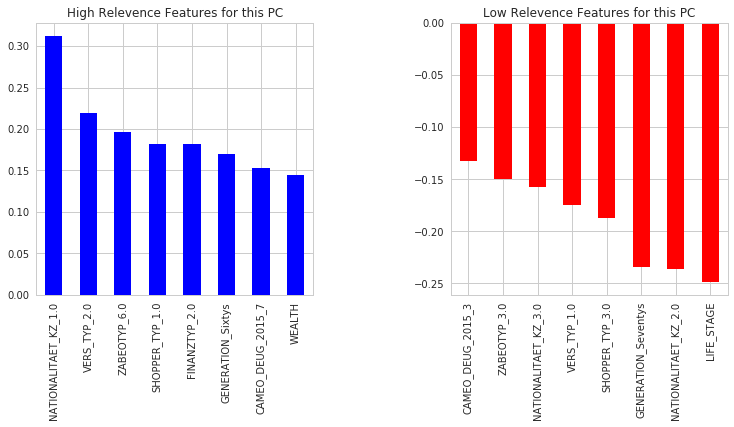

In [104]:
displayVarianceExplanation_Features(clust_components_df,16,8,multicomp=False)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.